# WaveNet Starter using RAW EEG Features!
This notebook is a WaveNet starter for Kaggle's Brain comp. It achieves `CV 0.91` and `LB 0.66`. Note that submitting train means achieves `CV 1.26` and `LB 0.97` [[here][1]]. So this notebook's WaveNet is successfully learning to predict brain events from raw EEG waveforms!

This model only uses two features. We can engineer more features and/or modify the model architecture to improve CV score and LB score. Furthermore we can build 1 model which inputs both spectrogram images and eeg waveforms. The two EEG features in this notebook are:
* feature 1 : `Fp1 minus O1`
* feature 2 : `Fp2 minus O2`

Feature 1 is the beginning of the montage chains `LL` and `LP` minus the ending of montage `LL` and `LP`. And feature 2 is the beginning of the montage chains `RL` and `RP` minus the ending of montage `RL` and `RP`.
![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/montage.png)

# UPDATE
In version 7 and 8, we add more features and update the model architecture to evaluate each montage chain separately and then concatenate the features. This new architecture is motivated by the discovery of a better formula to utilize EEG explained in discussion [here][2]

* Version 5,6: Use 2 features - CV 0.91 LB 0.66
* Version 7,8: Use 8 features grouped as 4 chains. Downsample time 5x - **CV 0.81 LB 0.53**, wow!

We train our new model in version 7, then save model weights. Then load model into version 8 to submit to LB.

![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/wave-model.png)

# Train and Infer Tricks
We train the fold models in version 7 of the notebook and submit to Kaggle LB in version 8 of the notebook. This makes submission faster because we train the fold models for 30 minutes in version 7 then save them. In version 8, we just load the models without needing to retrain models during Kaggle submit. (And we train our old model in 5 annd submit in 6).

Version 4 uses `1xP100` GPU with full precision and takes 1 hour to train 5 folds 5 epochs of WaveNet. Version 5 uses `2xT4` GPU with mixed precision and takes 30 minutes to train 5 folds 5 epochs of WaveNet. 

[1]: https://www.kaggle.com/code/seshurajup/eda-train-csv
[2]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/469760

# Load Train Data

In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt

train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print( train.shape )
display( train.head() )

# CHOICE TO CREATE OR LOAD EEGS FROM NOTEBOOK VERSION 1
CREATE_EEGS = False
TRAIN_MODEL = True

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# Raw EEG Features

In [2]:
df = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1000913311.parquet')
FEATS = df.columns
print(f'There are {len(FEATS)} raw eeg features')
print( list(FEATS) )


There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [3]:
print('We will use the following subset of raw EEG features:')
FEATS = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS,range(len(FEATS)))}
print( list(FEATS) )

We will use the following subset of raw EEG features:
['Fp1', 'T3', 'C3', 'O1', 'Fp2', 'C4', 'T4', 'O2']


In [4]:
def eeg_from_parquet(parquet_path, display=False):
    
    # EXTRACT MIDDLE 50 SECONDS
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    
    # CONVERT TO NUMPY
    data = np.zeros((10_000,len(FEATS)))
    for j,col in enumerate(FEATS):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
            
        data[:,j] = x
        
        if display: 
            if j!=0: offset += x.max()
            plt.plot(range(10_000),x-offset,label=col)
            offset -= x.min()
            
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()
        
    return data

In [5]:
# %%time

# all_eegs = {}
# DISPLAY = 4
# EEG_IDS = train.eeg_id.unique()
# PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'

# for i,eeg_id in enumerate(EEG_IDS):
#     if (i%100==0)&(i!=0): print(i,', ',end='') 
    
#     # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
#     data = eeg_from_parquet(f'{PATH}{eeg_id}.parquet', display=i<DISPLAY)              
#     all_eegs[eeg_id] = data
    
#     if i==DISPLAY:
#         if CREATE_EEGS:
#             print(f'Processing {train.eeg_id.nunique()} eeg parquets... ',end='')
#         else:
#             print(f'Reading {len(EEG_IDS)} eeg NumPys from disk.')
#             break
            
# if CREATE_EEGS: 
#     np.save('eegs',all_eegs)
# else:
all_eegs = np.load('/kaggle/input/brain-eegs/eegs.npy',allow_pickle=True).item()

# Deduplicate Train EEG Id

In [6]:
# LOAD TRAIN 
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

train = df.groupby('eeg_id')[['patient_id']].agg('first')

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
train = train.loc[train.eeg_id.isin(EEG_IDS)]
print('Train Data with unique eeg_id shape:', train.shape )
train.head()

Train Data with unique eeg_id shape: (17089, 9)


,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


# Butter Low-Pass Filter

In [7]:
# from scipy.signal import butter, lfilter

# def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
#     nyquist = 0.5 * sampling_rate
#     normal_cutoff = cutoff_freq / nyquist
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     filtered_data = lfilter(b, a, data, axis=0)
#     return filtered_data

In [8]:
# FREQS = [1,2,4,8,16][::-1]
# x = [all_eegs[EEG_IDS[0]][:,0]]

# for k in FREQS:
#     x.append( butter_lowpass_filter(x[0], cutoff_freq=k) )

# plt.figure(figsize=(20,20))
# plt.plot(range(10_000),x[0], label='without filter')
# for k in range(1,len(x)):
#     plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {FREQS[k-1]}Hz')
# plt.legend()
# plt.title('Butter Low-Pass Filter Examples',size=18)
# plt.show()

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft, spectrogram, welch, butter, lfilter
import matplotlib.colors

# # Assuming all_eegs is already loaded
# eeg_data = all_eegs[EEG_IDS[0]]  # Use the first EEG signal for this example
# # Use the first channel of the EEG data
# x = eeg_data[:, 0]

# # Apply the low-pass filter
# filtered_x = butter_lowpass_filter(x)
# plt.plot(filtered_x)

# #spectrogram calc
# f, t, Sxx = spectrogram(np.array(filtered_x), fs=200, nperseg=200, noverlap=int(200*0.8), scaling='density', return_onesided=True)
# Sxx_db = 10*np.log10(Sxx)

# plt.figure(figsize=(10, 6))
# plt.pcolormesh(Sxx_db, cmap='jet')# Plot the resultplt.title('STFT Magnitude of Filtered EEG Signal (dB)')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar(label='Magnitude (dB)')



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import spectrogram, butter, lfilter
# import matplotlib

# # Function for low-pass filtering
# def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
#     nyquist = 0.5 * sampling_rate
#     normal_cutoff = cutoff_freq / nyquist
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     filtered_data = lfilter(b, a, data, axis=0)
#     return filtered_data

# # Assuming all_eegs is already loaded
# eeg_data = all_eegs[EEG_IDS[0]]  # Use the first EEG signal for this example

# # Use the first channel of the EEG data
# filtered_eeg_data = butter_lowpass_filter(eeg_data)
# FEATS = ['Fp1', 'T3', 'C3', 'O1', 'Fp2', 'C4', 'T4', 'O2']
# FEAT2IDX = {x: y for y, x in enumerate(FEATS)}

# sample = np.zeros((filtered_eeg_data.shape[0], 8))
# sample[:,0] = eeg_data[:,FEAT2IDX['Fp1']] - eeg_data[:,FEAT2IDX['T3']]
# sample[:,1] = eeg_data[:,FEAT2IDX['T3']] - eeg_data[:,FEAT2IDX['O1']]
# sample[:,2] = eeg_data[:,FEAT2IDX['Fp1']] - eeg_data[:,FEAT2IDX['C3']]
# sample[:,3] = eeg_data[:,FEAT2IDX['C3']] - eeg_data[:,FEAT2IDX['O1']]
# sample[:,4] = eeg_data[:,FEAT2IDX['Fp2']] - eeg_data[:,FEAT2IDX['C4']]
# sample[:,5] = eeg_data[:,FEAT2IDX['C4']] - eeg_data[:,FEAT2IDX['O2']]
# sample[:,6] = eeg_data[:,FEAT2IDX['Fp2']] - eeg_data[:,FEAT2IDX['T4']]
# sample[:,7] = eeg_data[:,FEAT2IDX['T4']] - eeg_data[:,FEAT2IDX['O2']]

# # Function to plot spectrogram
# def plot_spectrogram(data, title, ax):
#     f, t, Sxx = spectrogram(data, fs=200, nperseg=200, noverlap=int(200 * 0.8), scaling='density', return_onesided=True)
#     Sxx_db = 10 * np.log10(np.abs(Sxx)**2 + 1e-10)  # Add a small value to avoid log(0)
#     mn = np.min(Sxx_db)
#     mx = np.max(Sxx_db)
#     normalize_color= matplotlib.colors.Normalize(vmin=mn, vmax=mx)
#     cax = ax.pcolormesh(t, f, Sxx_db, cmap='jet', norm=normalize_color)
#     ax.set_title(title)
#     ax.set_ylabel('Frequency [Hz]')
#     ax.set_xlabel('Time [sec]')
#     return cax

# # Plot spectrograms for each feature in a 4x2 grid
# fig, axs = plt.subplots(4, 2, figsize=(20, 20))

# for i in range(8):
#     row, col = divmod(i, 2)
#     cax = plot_spectrogram(sample[:, i], f'Feature {i + 1}', axs[row, col])

# # Adjust layout
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# fig.colorbar(cax, ax=axs, orientation='horizontal', fraction=0.025, pad=0.04)
# plt.show()




In [11]:
def average_spectrogram(data1, data2):
    f1, t1, Sxx1 = spectrogram(data1, fs=200, nperseg=200, nfft=512, noverlap=int(200 * 0.8), scaling='density', return_onesided=True)
    f2, t2, Sxx2 = spectrogram(data2, fs=200, nperseg=200, nfft=512, noverlap=int(200 * 0.8), scaling='density', return_onesided=True)
    Sxx_avg = (Sxx1 + Sxx2) / 2
    Sxx_avg_db = 10 * np.log10(np.abs(Sxx_avg)**2 + 1e-10)  # Add a small value to avoid log(0)
#     print(Sxx_avg_db.shape)
    return t1, f1, Sxx_avg_db
   



In [12]:
def spectrogram1(data1):
    f1, t1, Sxx1 = spectrogram(data1, fs=200, nperseg=200, nfft=512, noverlap=int(200 * 0.8), scaling='density', return_onesided=True)
#     f2, t2, Sxx2 = spectrogram(data2, fs=200, nperseg=200, nfft=512, noverlap=int(200 * 0.8), scaling='density', return_onesided=True)
#     Sxx_avg = (Sxx1 + Sxx2) / 2
    Sxx_avg_db = 10 * np.log10(np.abs(Sxx1)**2 + 1e-10)  # Add a small value to avoid log(0)
#     print(Sxx_avg_db.shape)
    return t1, f1, Sxx_avg_db

# Data Loader with Butter Low-Pass Filter

In [13]:
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, eegs=all_eegs, mode='train',
                 downsample=1): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.eegs = eegs
        self.mode = mode
        self.downsample = downsample
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X[:,::self.downsample,:], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
    
        X = np.zeros((len(indexes),257,246,4),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        
        sample = np.zeros((257,246,X.shape[-1]))
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]      
            data = self.eegs[row.eeg_id]
            
            
            # FEATURE ENGINEER

            _,_,spec0 = average_spectrogram(data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']],
                                                 data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']])
            sample[:, :, 0] = spec0
#             print(f'the spec shape is {spec0.shape}')
            _,_,sample[:, :, 1] = average_spectrogram(data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']],
                                                 data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']])
            _,_,sample[:, :, 2] = average_spectrogram(data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']],
                                                 data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']])
            _,_,sample[:, :, 3] = average_spectrogram(data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']],
                                                 data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']])
            sample[:, :, 0] = (sample[:, :, 0]-sample[:, :, 0].min())/(sample[:, :, 0].max()-sample[:, :, 0].min())
            sample[:, :, 1] = (sample[:, :, 1]-sample[:, :, 1].min())/(sample[:, :, 1].max()-sample[:, :, 1].min())
            sample[:, :, 2] = (sample[:, :, 2]-sample[:, :, 2].min())/(sample[:, :, 2].max()-sample[:, :, 2].min())
            sample[:, :, 3] = (sample[:, :, 3]-sample[:, :, 3].min())/(sample[:, :, 3].max()-sample[:, :, 3].min())
            X[j,] = sample
            if self.mode!='test':
                y[j] = row[TARGETS]
            
        return X[:,:224, :224,:],y

In [14]:
# train = pd.DataFrame({'eeg_id': [0, 1, 2], 'TARGETS': [0, 1, 1]})  # Example dataframe
# eegs = {0: np.random.rand(500, 500), 1: np.random.rand(500, 500), 2: np.random.rand(500, 500)}  # Example EEG data
train_index = [p for p in range(64)]
# gen = DataGenerator(train, shuffle=False, eegs=eegs)
train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
for X, y in train_gen:
    print(X.shape, y.shape)
    break

(32, 224, 224, 4) (32, 6)


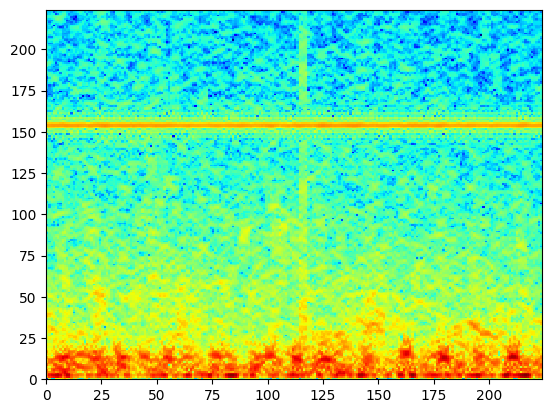

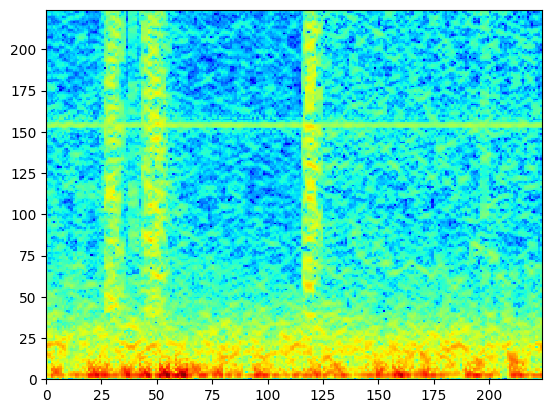

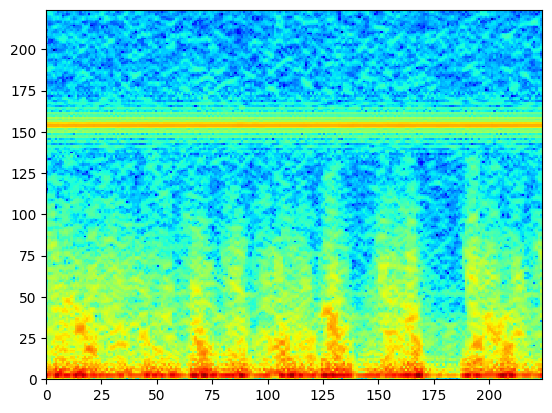

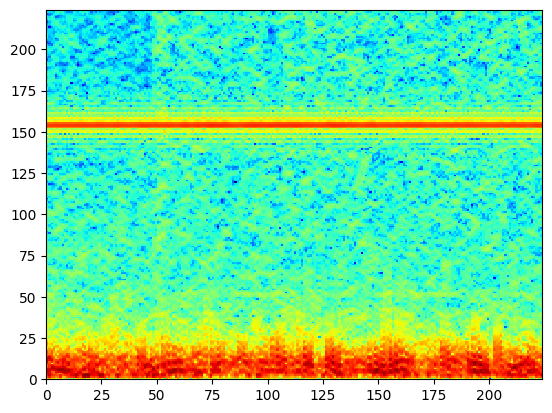

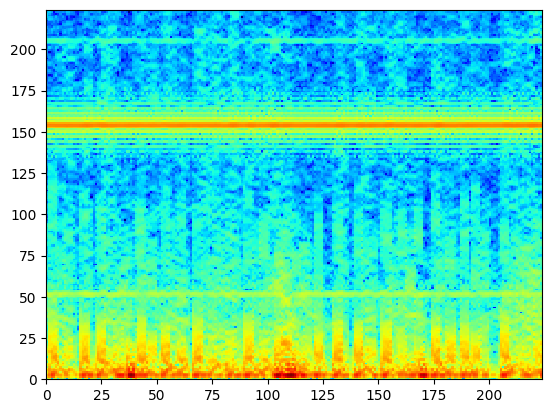

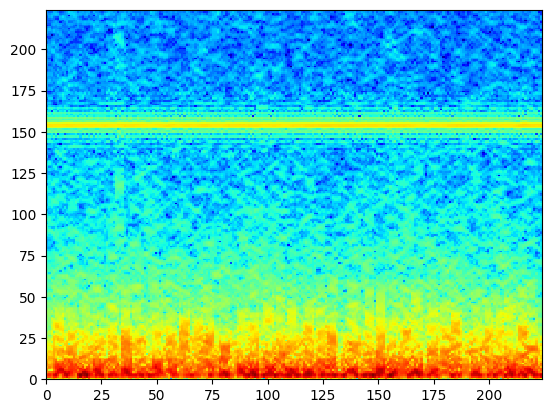

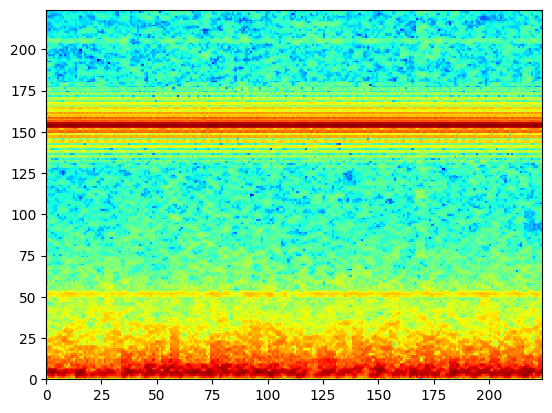

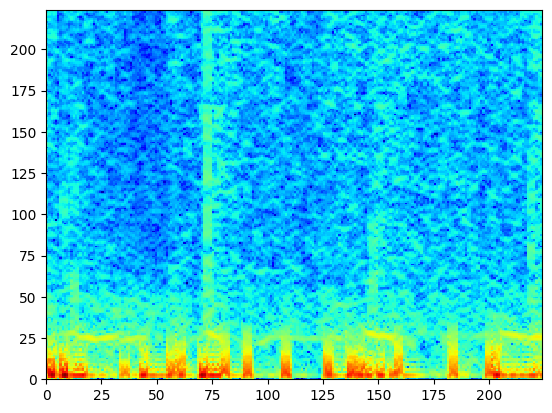

In [15]:
import matplotlib.pyplot as plt
for ii in range(8):
    mn = np.min(X[ii,:,:,0])
    mx = np.max(X[ii,:,:,0])
    normalize_color= matplotlib.colors.Normalize(vmin=mn, vmax=mx)
    plt.figure()
    plt.pcolormesh(X[ii,:,:,0], cmap='jet', norm=normalize_color)

# Display Data Loader

# Initialize GPUs

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

TensorFlow version = 2.13.0
Using 1 GPU


In [17]:
# USE MIXED PRECISION
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


# Build CNN Model

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ConvNeXtSmall,MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
def build_model():
        
    # INPUT 
    inp = tf.keras.Input(shape=(224,224,4))
    x = tf.keras.layers.Conv2D(3, kernel_size=(3,3), activation='gelu', padding='same')(inp)
    # Load the VGG16 model
    base_model = MobileNetV3Small(weights=None, include_top=False, input_shape=(224, 224, 3))
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
#     predictions = Dense(10, activation='softmax')(x)
    y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    model.summary()
#     opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    opt = tf.keras.optimizers.AdamW(weight_decay=0.1)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

# Train Group KFold

In [ ]:
VERBOSE = 1
FOLDS_TO_TRAIN = 5
if not os.path.exists('WaveNet_Model'):
    os.makedirs('WaveNet_Model')

from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

all_oof = []; all_oof2 = []; all_true = []
gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    # TRAIN MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if TRAIN_MODEL:
        model.fit(train_gen, verbose=VERBOSE,
              validation_data = valid_gen,
              epochs=50)
        model.save_weights(f'WaveNet_Model/WaveNet_fold{i}.h5')
    else:
        model.load_weights(f'/kaggle/input/brain-eegs/WaveNet_Model/WaveNet_fold{i}.h5')
    
    # WAVENET OOF
    oof = model.predict(valid_gen, verbose=VERBOSE)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    # TRAIN MEAN OOF
    y_train = train.iloc[train_index][TARGETS].values
    y_valid = train.iloc[valid_index][TARGETS].values
    oof = y_valid.copy()
    for j in range(6):
        oof[:,j] = y_train[:,j].mean()
    oof = oof / oof.sum(axis=1,keepdims=True)
    all_oof2.append(oof)
    
    del model, oof, y_train, y_valid
    gc.collect()
    
    if i==FOLDS_TO_TRAIN-1: break
    
all_oof = np.concatenate(all_oof)
all_oof2 = np.concatenate(all_oof2)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       111       
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 576)               0         
                          

/tmp/ipykernel_26/44021945.py:57: RuntimeWarning: invalid value encountered in divide
  sample[:, :, 0] = (sample[:, :, 0]-sample[:, :, 0].min())/(sample[:, :, 0].max()-sample[:, :, 0].min())
/tmp/ipykernel_26/44021945.py:58: RuntimeWarning: invalid value encountered in divide
  sample[:, :, 1] = (sample[:, :, 1]-sample[:, :, 1].min())/(sample[:, :, 1].max()-sample[:, :, 1].min())
/tmp/ipykernel_26/44021945.py:59: RuntimeWarning: invalid value encountered in divide
  sample[:, :, 2] = (sample[:, :, 2]-sample[:, :, 2].min())/(sample[:, :, 2].max()-sample[:, :, 2].min())
/tmp/ipykernel_26/44021945.py:60: RuntimeWarning: invalid value encountered in divide
  sample[:, :, 3] = (sample[:, :, 3]-sample[:, :, 3].min())/(sample[:, :, 3].max()-sample[:, :, 3].min())


428/428 [==============================] - 376s 802ms/step - loss: 1.1375 - val_loss: 1.3697
Epoch 2/50
391/428 [==========================>...] - ETA: 23s - loss: 0.9347

VMRI


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNetV3Small, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import GroupKFold
import numpy as np
import gc

def build_model(base_model_name='MobileNetV3Small'):
    # INPUT
    inp = tf.keras.Input(shape=(224, 224, 4))
    x = Conv2D(3, kernel_size=(3, 3), activation='gelu', padding='same')(inp)

    # Choose the base model
    if base_model_name == 'MobileNetV3Small':
        base_model = MobileNetV3Small(weights=None, include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(weights=None, include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError("Unsupported base model name")

    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    y = Dense(6, activation='softmax', dtype='float32')(x)

    # COMPILE MODEL
    model = Model(inputs=inp, outputs=y)
    model.summary()
    opt = AdamW(weight_decay=0.1)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)

    return model

# Example usage
VERBOSE = 1
FOLDS_TO_TRAIN = 5
if not os.path.exists('WaveNet_Model'):
    os.makedirs('WaveNet_Model')

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
    print('#' * 25)
    print(f'### Fold {i+1}')
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#' * 25)

    # TRAIN MODEL
    tf.keras.backend.clear_session()
    with strategy.scope():
        model = build_model(base_model_name='ResNet50')  # Change model name as needed

    if TRAIN_MODEL:
        model.fit(train_gen, verbose=VERBOSE, validation_data=valid_gen, epochs=50)
        model.save_weights(f'WaveNet_Model/WaveNet_fold{i}.h5')
    else:
        model.load_weights(f'/kaggle/input/brain-eegs/WaveNet_Model/WaveNet_fold{i}.h5')

    # WAVENET OOF
    oof = model.predict(valid_gen, verbose=VERBOSE)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)

    # TRAIN MEAN OOF
    y_train = train.iloc[train_index][TARGETS].values
    y_valid = train.iloc[valid_index][TARGETS].values
    oof = y_valid.copy()
    for j in range(6):
        oof[:, j] = y_train[:, j].mean()
    oof = oof / oof.sum(axis=1, keepdims=True)
    all_oof2.append(oof)

    del model, oof, y_train, y_valid
    gc.collect()

    if i == FOLDS_TO_TRAIN - 1: break

all_oof = np.concatenate(all_oof)
all_oof2 = np.concatenate(all_oof2)
all_true = np.concatenate(all_true)


# CV Score for WaveNet

In [ ]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

# CV Score using Train Means

In [ ]:
oof = pd.DataFrame(all_oof2.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with Train Means =',cv)

# Submit to Kaggle LB

In [ ]:
del all_eegs, train; gc.collect()
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape:',test.shape)
test.head()

In [ ]:
all_eegs2 = {}
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'

print('Processing Test EEG parquets...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = data

In [ ]:
# INFER MLP ON TEST
preds = []
model = build_model()
test_gen = DataGenerator(test, shuffle=False, batch_size=64, eegs=all_eegs2, mode='test')

print('Inferring test... ',end='')
for i in range(FOLDS_TO_TRAIN):
    print(f'fold {i+1}, ',end='')
    if TRAIN_MODEL:
        model.load_weights(f'WaveNet_Model/WaveNet_fold{i}.h5')
    else:
        model.load_weights(f'/kaggle/input/brain-eegs/WaveNet_Model/WaveNet_fold{i}.h5')
    pred = model.predict(test_gen, verbose=0)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

In [ ]:
# CREATE SUBMISSION.CSV
from IPython.display import display

sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
display( sub.head() )

# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
print('Sub row 0 sums to:',sub.iloc[0,-6:].sum())